In [1]:
from utils import load_display_options, ignore_warnings
load_display_options()
ignore_warnings()

In [2]:
from visualisation.visualise import load_fonts, load_mpl_style
visualisation_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/src/visualisation"
font_path = visualisation_path + "/fonts"
# style_path = visualisation_path + "/mplstyle/lilac_pitch_clusters.mplstyle"

load_fonts(font_path)
# load_mpl_style(style_path)

In [3]:
import pandas as pd

Load Chain Data

In [23]:
summary = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/data/match_summary.csv")
chains = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/data/playing_style_chains_v2.csv")
player_stats = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/data/playing_style_stats_v2.csv")
match_id = "2022F4_Geelong_Sydney"
team = "Geelong"

Get Plot Data

In [24]:
from chain_utils import get_match, get_team

In [25]:
match_summary = get_match(summary, match_id)

match_chains = get_match(chains, match_id)
team_chains = get_team(match_chains, team)

match_player_stats = get_match(player_stats, match_id)
team_player_stats = get_team(match_player_stats, team)

In [37]:
match_summary['Q4_Score'].apply(lambda x: x.split(" - ")[0].split(".")[0])

412    20
Name: Q4_Score, dtype: object

In [38]:
def get_scores(summary):
    
    summary['Home_Goals'] = summary['Q4_Score'].apply(lambda x: x.split(" - ")[0].split(".")[0])
    summary['Home_Behinds'] = summary['Q4_Score'].apply(lambda x: x.split(" - ")[0].split(".")[1])
    summary['Home_Score'] = summary['Q4_Score'].apply(lambda x: x.split(" - ")[0].split(".")[2])
    
    summary['Away_Goals'] = summary['Q4_Score'].apply(lambda x: x.split(" - ")[1].split(".")[0])
    summary['Away_Behinds'] = summary['Q4_Score'].apply(lambda x: x.split(" - ")[1].split(".")[1])
    summary['Away_Score'] = summary['Q4_Score'].apply(lambda x: x.split(" - ")[1].split(".")[2])
    
    return summary

In [54]:
match_summary = get_scores(match_summary)
home_match_summary = match_summary[['Home_Team', 'Home_Goals', 'Home_Behinds', 'Home_Score']]
home_match_summary.columns = ['Team', 'Goals', 'Behinds', 'Score']

away_match_summary = match_summary[['Away_Team', 'Away_Goals', 'Away_Behinds', 'Away_Score']]
away_match_summary.columns = ['Team', 'Goals', 'Behinds', 'Score']
score_match_summary = pd.concat([home_match_summary, away_match_summary])
score_match_summary

,Team,Goals,Behinds,Score
412,Geelong,20,13,133
412,Sydney,8,4,52


In [67]:
def create_match_score_summary(match_summary):
    
    match_summary = get_scores(match_summary)
    
    home_match_summary = match_summary[['Home_Team', 'Home_Goals', 'Home_Behinds', 'Home_Score']]
    home_match_summary.columns = ['Team', 'Goals', 'Behinds', 'Score']

    away_match_summary = match_summary[['Away_Team', 'Away_Goals', 'Away_Behinds', 'Away_Score']]
    away_match_summary.columns = ['Team', 'Goals', 'Behinds', 'Score']
    
    match_score_summary = pd.concat([home_match_summary, away_match_summary])
    
    return match_score_summary

In [68]:
def create_match_statistics_data(player_stats, score_summary):
    
    match_stats = player_stats.groupby('Team').sum()[['Disposals', 'Effective_Disposals', 'Goal_Assists', 'Pressure_Acts', 'Shots_At_Goal', 'Possessions', 'xScore', 'exp_offensive_value',  'exp_vaep_value_received', 'xDisposal']].reset_index()
    match_stats = match_stats.merge(score_summary, how = 'left', left_on='Team', right_on='Team')
    match_stats = match_stats.set_index('Team').T.reset_index()
    match_stats.rename(columns={'index': 'Statistics'}, inplace=True)

    table_order = ['Score', 'xScore', 'Goals', 'Behinds', 'Shots_At_Goal', 'Goal_Assists', 'Possessions', 'Disposals', 'Effective_Disposals', 'xDisposal', 'exp_offensive_value', 'exp_vaep_value_received', 'Pressure_Acts']
    match_stats['Statistics'] = pd.Categorical(match_stats['Statistics'], categories=table_order, ordered=True)
    match_stats = match_stats.sort_values('Statistics').set_index('Statistics')
    
    return match_stats

In [69]:
match_summary = get_match(summary, match_id)
match_player_stats = get_match(player_stats, match_id)
match_score_summary = create_match_score_summary(match_summary)
match_stats = create_match_statistics_data(match_player_stats, match_score_summary)

In [71]:
def create_match_stats(summary, player_stats, match_id):
    
    match_summary = get_match(summary, match_id)
    match_player_stats = get_match(player_stats, match_id)
    match_score_summary = create_match_score_summary(match_summary)
    match_stats = create_match_statistics_data(match_player_stats, match_score_summary)

    return match_stats

In [72]:
match_stats = create_match_stats(summary, player_stats, match_id)
match_stats

Team,Geelong,Sydney
Statistics,,
Score,133,52
xScore,105.171135,42.869727
Goals,20,8
Behinds,13,4
Shots_At_Goal,35,13
Goal_Assists,14,5
Possessions,404,299
Disposals,395,304
Effective_Disposals,296.0,232.0


In [150]:
def format_table_numbers(match_stats):
    
    # 
    match_stats = match_stats.astype(float)
    
    # Integers
    integer_cols = ['Score', 'Goals', 'Behinds', 'Shots_At_Goal', 'Goal_Assists', 'Possessions', 'Disposals', 'Effective_Disposals', 'Pressure_Acts']
    match_stats.loc[integer_cols] = match_stats.loc[integer_cols].astype(int)
    
    # Floats
    float_cols = ['xScore', 'xDisposal', 'exp_offensive_value', 'exp_vaep_value_received']
    match_stats.loc[float_cols] = match_stats.loc[float_cols].astype(float).round(1)
    
    return match_stats

In [151]:
match_stats = format_table_numbers(match_stats)

In [154]:
match_stats

Team,Geelong,Sydney
Statistics,,
Score,133.0,52.0
xScore,105.2,42.9
Goals,20.0,8.0
Behinds,13.0,4.0
Shots_At_Goal,35.0,13.0
Goal_Assists,14.0,5.0
Possessions,404.0,299.0
Disposals,395.0,304.0
Effective_Disposals,296.0,232.0


Create Table Plot

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
def get_normalised_match_stats(match_stats):
    
    return match_stats.div(match_stats.sum(axis=1), axis=0)

In [175]:
norm_match_stats = match_stats.div(match_stats.sum(axis=1), axis=0)

In [ ]:
def plot_heatmap(ax, data):
    
    heatmap = sns.heatmap(data, ax=ax, cbar=False, cmap = "coolwarm")

    ax.set_xticklabels(list(match_stats.columns))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', which='both', top=False)

    ax.set_yticklabels(list(match_stats.index))
    ax.tick_params(axis='y', which='both', left=False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title('Match Statistics')
    
    return ax

In [ ]:
def annotate_heatmap(ax, data):
    
    data_array = np.array(data)
    annotations = [["{:.0f}", "{:.0f}"], 
                ["{:.1f}", "{:.1f}"],
                ["{:.0f}", "{:.0f}"],
                ["{:.0f}", "{:.0f}"],
                ["{:.0f}", "{:.0f}"],
                ["{:.0f}", "{:.0f}"],
                ["{:.0f}", "{:.0f}"],
                ["{:.0f}", "{:.0f}"],
                ["{:.0f}", "{:.0f}"], 
                ["{:.1f}", "{:.1f}"], 
                ["{:.1f}", "{:.1f}"], 
                ["{:.1f}", "{:.1f}"], 
                ["{:.0f}", "{:.0f}"]]

    for i in range(len(annotations)):
        for j in range(len(annotations[0])):
            formatted_text = annotations[i][j].format(data_array[i][j])
            ax.text(j + 0.5, i + 0.5, formatted_text, 
                    ha='center', va='center', fontsize=10, color='white')
    
    return ax

Text(0.5, 1.0, 'Match Statistics')

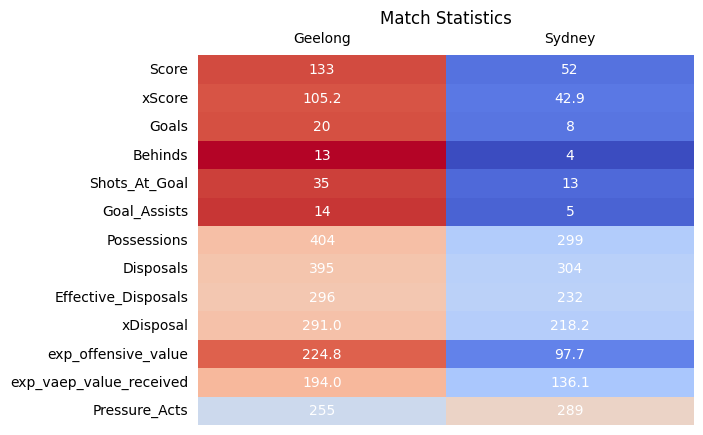

In [207]:
# Create figure and axis
fig, ax = plt.subplots()
# fig.dpi = 250

# Create a heatmap using imshow
heatmap = sns.heatmap(norm_match_stats, ax=ax, cbar=False, cmap = "coolwarm")

ax.set_xticklabels(list(match_stats.columns))
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both', top=False)

ax.set_yticklabels(list(match_stats.index))
ax.tick_params(axis='y', which='both', left=False)

ax.set_xlabel("")
ax.set_ylabel("")

match_stats_array = np.array(match_stats)
annotations = [["{:.0f}", "{:.0f}"], 
               ["{:.1f}", "{:.1f}"],
               ["{:.0f}", "{:.0f}"],
               ["{:.0f}", "{:.0f}"],
               ["{:.0f}", "{:.0f}"],
               ["{:.0f}", "{:.0f}"],
               ["{:.0f}", "{:.0f}"],
               ["{:.0f}", "{:.0f}"],
               ["{:.0f}", "{:.0f}"], 
               ["{:.1f}", "{:.1f}"], 
               ["{:.1f}", "{:.1f}"], 
               ["{:.1f}", "{:.1f}"], 
               ["{:.0f}", "{:.0f}"]]

for i in range(len(annotations)):
    for j in range(len(annotations[0])):
        formatted_text = annotations[i][j].format(match_stats_array[i][j])
        ax.text(j + 0.5, i + 0.5, formatted_text, 
                ha='center', va='center', fontsize=10, color='white')

# Add labels and title
ax.set_title('Match Statistics')

<Axes: xlabel='Team', ylabel='Statistics'>

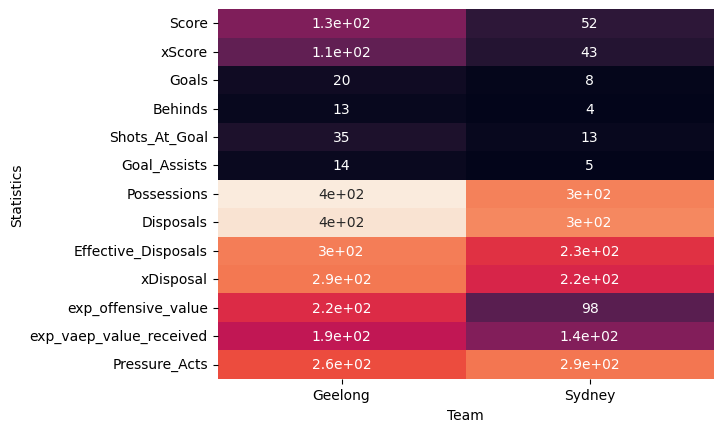

In [91]:
sns.heatmap(match_stats.astype(float), annot=True, cbar=False)